# Sentiment Analysis of Healthcare and Personal care products

## Business Understanding

This project is aimed towards understanding the sentiment of customer reviews in different social media platforms.

When customer likes and dislikes a product, it is highly likely that they post their review in their Twitter or FaceBook or any ther social platform.

Our objective is to build a model that is trained with the known positve and negative customer reviews from Amazon's Healthcare and personla care products.

**Dataset Description**
1. We want to know what is the postive and negative sentiments are. With Amazon's product review, we associate 4,5 ratings as positive, and 1, 2 ratings ar negative.

2. We want to focus only on Healthcare and Personal care products only. 


**How do we train our model and choose from the models trained?**
We experiemnt with different ML algorithms suh as Logistic Regression, SVC, Random Forest to classify our sentiments as positive or negative.

Based on the precision score, we choose our model after performing Hyper parameter tuning.

**What is the impact of our project?**

Not all the customers reach Customer Care when they face a trouble with the product that they recently purchased. Additionally not all customers write reviews. It would be worse for amazon if customers leave negative comments regarding their products on social media and amazon doesn't keep track of it the way it is able to for the reviews left on its website.

Using sentiment analysis, we can predict negative sentiments in customer reviews. This negative sentiments could be used to rectify the problem/issue that the customer is facing. We hope to use the same model to eventually run sentiment analysis on references made to amazon products on social media platforms where there is no review or rating readily available.

This helps in increasing customer satisfaction while increasing the range of purchase of the existing customers.

## Setup

### Importing Python Libraries

In [0]:
import pandas as pd
import re, string, unicodedata
import nltk
import inflect
import string
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import WhitespaceTokenizer
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Data Ingestion

In [0]:
!wget "https://raw.github.com/krithikaceg/Text_Analysis/master/Sentiment_Analysis/product_review_sentiment_analysis.csv.zip"

--2019-05-31 20:49:38--  https://raw.github.com/krithikaceg/Text_Analysis/master/Sentiment_Analysis/product_review_sentiment_analysis.csv.zip
Resolving raw.github.com (raw.github.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.github.com (raw.github.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/krithikaceg/Text_Analysis/master/Sentiment_Analysis/product_review_sentiment_analysis.csv.zip [following]
--2019-05-31 20:49:38--  https://raw.githubusercontent.com/krithikaceg/Text_Analysis/master/Sentiment_Analysis/product_review_sentiment_analysis.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 481210 (470K) [application/zip]
Saving to:

In [0]:
!unzip product_review_sentiment_analysis.csv.zip

Archive:  product_review_sentiment_analysis.csv.zip
  inflating: product_review_sentiment_analysis.csv  
   creating: __MACOSX/
  inflating: __MACOSX/._product_review_sentiment_analysis.csv  


In [0]:
input_data = pd.read_csv('product_review_sentiment_analysis.csv')

## Data Understanding

In [0]:
print(input_data.columns)
print(input_data.info())
print(input_data.head())

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19009 entries, 0 to 19008
Data columns (total 9 columns):
reviewerID        19009 non-null object
asin              19009 non-null object
reviewerName      19008 non-null object
helpful           19009 non-null object
reviewText        19005 non-null object
overall           19009 non-null int64
summary           19009 non-null object
unixReviewTime    19009 non-null int64
reviewTime        19009 non-null object
dtypes: int64(2), object(7)
memory usage: 1.3+ MB
None
       reviewerID        asin  ... unixReviewTime   reviewTime
0  A35W3JQYP0M655  1933622865  ...     1306627200  05 29, 2011
1   A26EXMDN188M0  1933622865  ...     1374796800  07 26, 2013
2  A15GHUAXG7RZ0B  1933622865  ...     1390521600  01 24, 2014
3   ASXDRKXJPRVUA  7884890364  ...     1374019200  07 17, 2013
4   AA5KIZ

In [0]:
input_data.isnull().sum()

reviewerID        0
asin              0
reviewerName      1
helpful           0
reviewText        4
overall           0
summary           0
unixReviewTime    0
reviewTime        0
dtype: int64

In [0]:
input_data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A35W3JQYP0M655,1933622865,"John Thomas... ""New England...USA""","[68, 87]",I recently saw this at a local AC Moore store....,1.0,...Wear Glasses And Forget This,1.306627e+09,"05 29, 2011"
1,A26EXMDN188M0,1933622865,Lysan,"[0, 0]",Less helpful than a good magnifying glass. Jus...,2.0,Disappointed!,1.374797e+09,"07 26, 2013"
2,A15GHUAXG7RZ0B,1933622865,toBie11,"[0, 0]",Bought for my mother due her eye sight going d...,2.0,Mighty Bright Rigid Page Magnifier,1.390522e+09,"01 24, 2014"
3,ASXDRKXJPRVUA,7884890364,David Diamond,"[24, 25]",ONE STAR:The Maxell LR44 10-pack photo shows t...,1.0,"If your package is orange & black, then send i...",1.374019e+09,"07 17, 2013"
4,AA5KIZVGT7IOV,7884890364,"Fort Worth 2 ""My strength is renewed!""","[0, 0]",These did not work at all - absent of enough p...,1.0,No Power,1.389053e+09,"01 7, 2014"


In [0]:
input_data["overall"].unique()

array([ 1.,  2.,  5.,  4., nan])

## Data Preparation

In [0]:
# considering only reviewText and overall
input_data = input_data[['reviewText', 'overall']]

# drop any rows with NA for reviewText
input_data.dropna(how='any',axis=0, inplace=True) 

# drop neutral reviews
input_data.drop(input_data[input_data.overall == 3].index, inplace=True)

# rename column
input_data.rename(index=str, columns={"reviewText": "review"}, inplace=True)

# create the sentiment column
input_data["sentiment"] = input_data["overall"].apply(lambda x: 0 if x<3 else (1 if x>3 else 0))

input_data.head()

,review,overall,sentiment
0,I recently saw this at a local AC Moore store....,1,0
1,Less helpful than a good magnifying glass. Jus...,2,0
2,Bought for my mother due her eye sight going d...,2,0
3,ONE STAR:The Maxell LR44 10-pack photo shows t...,1,0
4,These did not work at all - absent of enough p...,1,0


In [0]:
input_data.isnull().sum()

review       0
overall      0
sentiment    0
dtype: int64

In [0]:
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
input_data["review_clean"] = input_data["review"].apply(lambda x: clean_text(x))
#clean_text(input_data["review"][0])


## EDA

### Class Balance Check

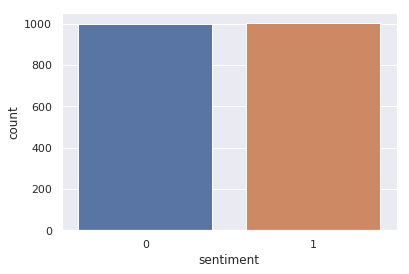

In [0]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="sentiment", data=input_data)

### Word Cloud

**Word cloud for positive sentiment**

In [0]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

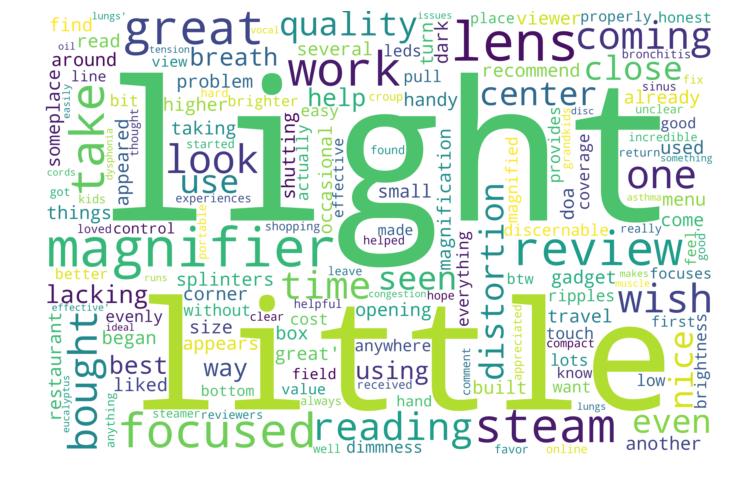

In [0]:
sentiment_p= input_data[input_data.sentiment==1.0]
sentiment_p_text = sentiment_p['review_clean'].values
len(sentiment_p_text)

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(sentiment_p_text))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'w',
    edgecolor = 'w')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**Word cloud for negative Sentiment**

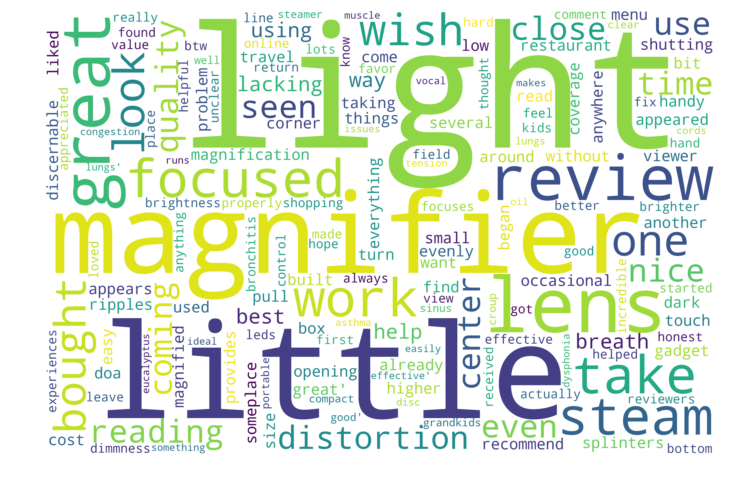

In [0]:
sentiment_p= input_data[input_data.sentiment==1.0]
sentiment_p_text = sentiment_p['review_clean'].values
len(sentiment_p_text)

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(sentiment_p_text))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'w',
    edgecolor = 'w')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Modeling Preparation

### Text Vectorization

#### Bag of Words

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
import string
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    '''
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

bow_transformer = CountVectorizer(analyzer=text_process).fit(input_data["review_clean"])
len(bow_transformer.vocabulary_)

11956

In [0]:
bow = bow_transformer.transform([input_data["review_clean"][1]])
bow

<1x11956 sparse matrix of type '<class 'numpy.int64'>'
	with 18 stored elements in Compressed Sparse Row format>

**Feature Names**

In [0]:
bow_transformer.get_feature_names()

['aa',
 'aaa',
 'aaaaa',
 'aaas',
 'aapowered',
 'aarp',
 'aas',
 'abandoned',
 'abandoning',
 'abbott',
 'abbottrochebayer',
 'abcessed',
 'abdomen',
 'abdominal',
 'ability',
 'able',
 'abnormal',
 'abnormalities',
 'aboard',
 'aborted',
 'aboutwith',
 'abraded',
 'abrasion',
 'abrasionsif',
 'abrasive',
 'abrasiveness',
 'abrasiverembrandt',
 'abreva',
 'abs',
 'abscess',
 'absent',
 'absentminded',
 'absolute',
 'absolutely',
 'absolutley',
 'absolve',
 'absorb',
 'absorbant',
 'absorbed',
 'absorbent',
 'absorber',
 'absorbers',
 'absorbing',
 'absorbs',
 'absorption',
 'absurd',
 'abuse',
 'abut',
 'ac',
 'academia',
 'accelereate',
 'accept',
 'acceptable',
 'accepted',
 'access',
 'accessories',
 'accident',
 'accidental',
 'accidentally',
 'accidently',
 'accidents',
 'accommodate',
 'accompanied',
 'accomplished',
 'according',
 'accordingly',
 'account',
 'accuarate',
 'accucheck',
 'accuchek',
 'accumulate',
 'accumulated',
 'accumulates',
 'accumulationthis',
 'accuracy',


#### TF-IDF

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# list of text documents

# create the transform
vectorizer = TfidfVectorizer()
# tokenize and build vocab
#input_data["review_v"] = input_data["review_clean"].apply(lambda x: np.str_(x))
x = vectorizer.fit_transform(input_data["review_clean"])
#X_test = vectorizer.transform(corpus_test)
#vectorizer.fit(x)
# summarize
vectorizer.vocabulary_
#print(vectorizer.idf_)

{'recently': 7036,
 'saw': 7556,
 'local': 5043,
 'ac': 45,
 'moore': 5563,
 'store': 8445,
 'one': 5971,
 'open': 5988,
 'could': 1956,
 'try': 9276,
 'tried': 9243,
 'less': 4920,
 'minutes': 5466,
 'enough': 2935,
 'personally': 6342,
 'think': 8980,
 'worst': 9960,
 'ideas': 4295,
 'seen': 7690,
 'long': 5061,
 'time': 9053,
 'product': 6738,
 'annoying': 359,
 'tv': 9304,
 'commercials': 1701,
 'idea': 4292,
 'supposed': 8660,
 'easier': 2783,
 'hold': 4138,
 'thing': 8976,
 'book': 937,
 'hover': 4203,
 'continuously': 1882,
 'read': 6988,
 'opposed': 6008,
 'wearing': 9765,
 'glasses': 3727,
 'something': 8153,
 'newer': 5751,
 'model': 5512,
 'light': 4959,
 'come': 1688,
 'improvement': 4358,
 'opinion': 6002,
 'question': 6897,
 'get': 3690,
 'right': 7381,
 'magnify': 5167,
 'page': 6167,
 'whatever': 9811,
 'using': 9507,
 'fact': 3153,
 'actually': 112,
 'works': 9945,
 'benefits': 787,
 'ends': 2908,
 'starters': 8356,
 'even': 3012,
 'reading': 6993,
 'books': 940,
 'req

#### Bi-gram Vectorizer

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vectorizer = TfidfVectorizer(ngram_range=(2, 2))
# tokenize and build vocab
#input_data["review_v"] = input_data["review_clean"].apply(lambda x: np.str_(x))
x = vectorizer.fit_transform(input_data["review_clean"])
#X_test = vectorizer.transform(corpus_test)
#vectorizer.fit(x)
# summarize
vectorizer.vocabulary_
#print(vectorizer.idf_)

{'recently saw': 49536,
 'saw local': 52411,
 'local ac': 34250,
 'ac moore': 225,
 'moore store': 38193,
 'store one': 58936,
 'one open': 41498,
 'open could': 41879,
 'could try': 13119,
 'try tried': 65692,
 'tried less': 65267,
 'less minutes': 32664,
 'minutes enough': 37485,
 'enough personally': 18381,
 'personally think': 44346,
 'think one': 63027,
 'one worst': 41741,
 'worst ideas': 72291,
 'ideas seen': 29000,
 'seen long': 53628,
 'long time': 34427,
 'time product': 63853,
 'product one': 46962,
 'one annoying': 41211,
 'annoying tv': 2413,
 'tv commercials': 65988,
 'commercials idea': 11932,
 'idea supposed': 28980,
 'supposed easier': 60077,
 'easier hold': 17307,
 'hold thing': 28031,
 'thing book': 62713,
 'book hover': 6586,
 'hover continuously': 28567,
 'continuously read': 12704,
 'read opposed': 48909,
 'opposed wearing': 42010,
 'wearing glasses': 70001,
 'glasses something': 24485,
 'something think': 56893,
 'think newer': 63025,
 'newer model': 39730,
 'mod

## Modeling and Evaluation

### Test Train Split

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(input_data['review_clean'], input_data['sentiment'], test_size=0.2, random_state=7)



### Vectorization

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
stop = stopwords.words('english')

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)



### Modeling and Evaluation without Grid Search

#### Logistic Regression

**Model: Sentiment Prediction using Logistic Regression**

In [0]:
model = LogisticRegression(penalty="l1", C=0.1)
model.fit(X_train, y_train)
preds = model.predict(X_test)
preds

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

**Evaluation:Confusion Matrix and Classification Report**

In [0]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))

[[195   0]
 [206   0]]


              precision    recall  f1-score   support

           0       0.49      1.00      0.65       195
           1       0.00      0.00      0.00       206

    accuracy                           0.49       401
   macro avg       0.24      0.50      0.33       401
weighted avg       0.24      0.49      0.32       401



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### SVC

**Model: Sentiment Prediction using SVC**

In [0]:
from sklearn.svm import SVC
svc = SVC()
model = SVC(probability=True, kernel="linear", class_weight="balanced")
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(preds)

[1 0 1 1 0 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 1 0 1 1 1 0 0 1 0
 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0 1 1 0 1 1 0 1 0 0 0 1 0 1 0
 0 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 1 0 0 0
 0 0 0 1 1 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 1 1
 1 0 0 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 0
 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0 0 0 1 0 0 1 1 1 0 0 1
 0 1 1 0 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 0 1 1 0 0 1 1 0 1 0 0 1 0 1
 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1 0 1 0 0 1 1
 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 0 1 0 0 1 1 1 1 1 0 0 0 1 1 0 1 0 0
 0 1 1 0 1 1 0 1 1 1 0 0 0 0 1 1 1 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0
 1 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 1 0]


**Evaluation: Confusion Matrix and Classification Report**

In [0]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))

[[144  51]
 [ 53 153]]


              precision    recall  f1-score   support

           0       0.73      0.74      0.73       195
           1       0.75      0.74      0.75       206

    accuracy                           0.74       401
   macro avg       0.74      0.74      0.74       401
weighted avg       0.74      0.74      0.74       401



#### Random Forest Classifier

**Model:  Sentiment Prediction using SVC**

In [0]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0) 
text_classifier.fit(X_train, y_train) 
preds = text_classifier.predict(X_test)  


**Evaluation: Confusion Matrix and Classification Report**


In [0]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))

[[176  19]
 [115  91]]


              precision    recall  f1-score   support

           0       0.60      0.90      0.72       195
           1       0.83      0.44      0.58       206

    accuracy                           0.67       401
   macro avg       0.72      0.67      0.65       401
weighted avg       0.72      0.67      0.65       401



### Grid Search: Modeling and Evaluation

**Model: Grid Search for Logistic Regression**

In [0]:
from sklearn.linear_model import LogisticRegressionCV

lr_params = {'penalty': ['l1','l2'],
          'solver':['liblinear'],
          'C': np.logspace(-10,10,21)}
lr = LogisticRegression(random_state=1)
# Define the gridsearchCV
lr_grid = GridSearchCV(lr, param_grid=lr_params, cv=3, n_jobs=-1, verbose=1)
# fit with the tranformed sparse matrix
lr_grid.fit(X_train, y_train)
print('Best Score:', lr_grid.best_score_)

# assign the best estimator to a variable
best_lr = lr_grid.best_estimator_
print('Best Params:', lr_grid.best_params_)

Fitting 3 folds for each of 42 candidates, totalling 126 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best Score: 0.7584269662921348
Best Params: {'C': 10.0, 'penalty': 'l2', 'solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:   18.4s finished


**Evaluation: Confusion Matrix and Classification Report**

Fitting 3 folds for each of 42 candidates, totalling 126 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:   17.0s finished


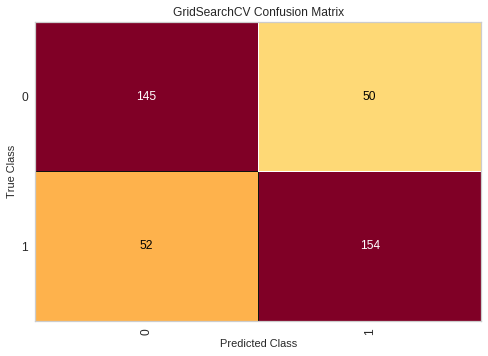

In [0]:
from yellowbrick.classifier import ConfusionMatrix
cm = ConfusionMatrix(lr_grid, classes=[0, 1])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.poof()

In [0]:
y_true, y_pred = y_test, lr_grid.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74       195
           1       0.75      0.75      0.75       206

    accuracy                           0.75       401
   macro avg       0.75      0.75      0.75       401
weighted avg       0.75      0.75      0.75       401



**Evaluation: ROC AUC**

Fitting 3 folds for each of 42 candidates, totalling 126 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:   17.1s finished


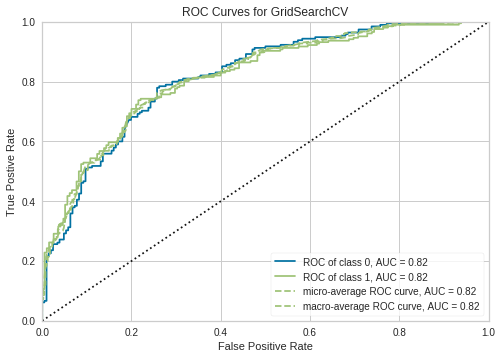

In [0]:
from yellowbrick.classifier import ROCAUC
classes=[0, 1]

# Instantiate the visualizer with the classification model
visualizer = ROCAUC(lr_grid, classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()  

### Grid Search for SVC

**Model: Grid Search for SVC**

In [0]:
from sklearn.svm import SVC

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]


svc = SVC()
# Define the gridsearchCV
svc_grid = GridSearchCV(svc, param_grid=tuned_parameters, cv=3, n_jobs=-1, verbose=1)
# fit with the tranformed sparse matrix
svc_grid.fit(X_train, y_train)
print('Best Score:', svc_grid.best_score_)

# assign the best estimator to a variable
best_svc = svc_grid.best_estimator_
print('Best Params:', svc_grid.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   14.7s finished


Best Score: 0.7621722846441947
Best Params: {'C': 1, 'kernel': 'linear'}


**Evaluation: Confusion Matrix and Classification report**

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   15.5s finished


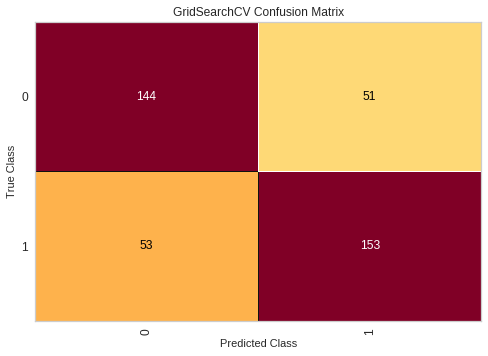

In [0]:
from yellowbrick.classifier import ConfusionMatrix
cm = ConfusionMatrix(svc_grid, classes=[0, 1])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.poof()

In [0]:
y_true, y_pred = y_test, svc_grid.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.74      0.73       195
           1       0.75      0.74      0.75       206

    accuracy                           0.74       401
   macro avg       0.74      0.74      0.74       401
weighted avg       0.74      0.74      0.74       401



**Evaluation: ROC AUC**

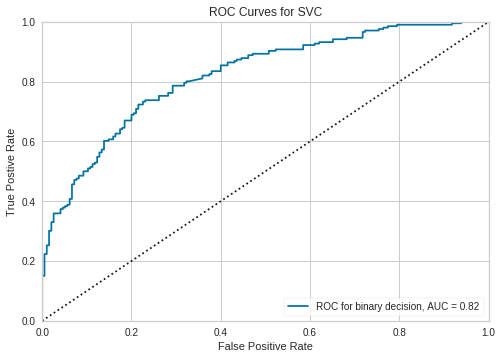

In [0]:
from yellowbrick.classifier import ROCAUC
classes=[0, 1]

#preds = svc_grid.predict(X_test)

# Instantiate the visualizer with the classification model
#visualizer = ROCAUC(model, ax, **kwargs)
svc = SVC(C= 1000, gamma= 0.001, kernel= 'rbf')
visualizer = ROCAUC(svc, micro=False, macro=False, per_class=False)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof() 
 

### Grid Search for Random Forest

**Model: Grid Search for Random Forest**

In [0]:
tuned_parameters = {'n_estimators': [10, 20, 50, 100],
                    'criterion': ['gini', 'entropy'],
                    'max_depth': [5, 10, 15, 20],
                    'max_features': ['auto', 'sqrt', 'log2']
                   }
rf = RandomForestClassifier() 
# Define the gridsearchCV
rf_grid = GridSearchCV(rf, param_grid=tuned_parameters, cv=3, n_jobs=-1, verbose=1)
# fit with the tranformed sparse matrix
rf_grid.fit(X_train, y_train)
print('Best Score:', rf_grid.best_score_)

# assign the best estimator to a variable
best_rf = rf_grid.best_estimator_
print('Best Params:', rf_grid.best_params_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:   14.2s


Best Score: 0.6722846441947565
Best Params: {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 100}


[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:   27.6s finished


**Evaluation: Confusion Matrix and Classification Report**

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:   30.6s finished


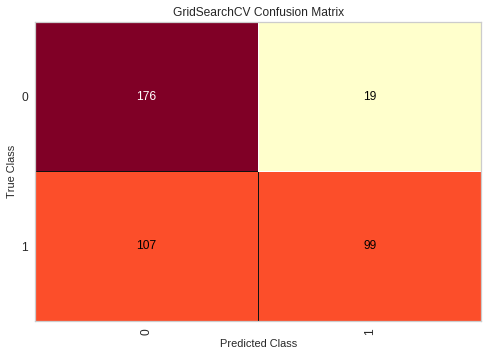

In [0]:
cm = ConfusionMatrix(rf_grid, classes=[0, 1])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.poof()

In [0]:
y_true, y_pred = y_test, rf_grid.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.99      0.92       354
           1       0.98      0.64      0.78       177

    accuracy                           0.88       531
   macro avg       0.92      0.82      0.85       531
weighted avg       0.89      0.88      0.87       531



**Evaluation: ROC AUC**

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 177 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 285 out of 288 | elapsed:   27.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:   27.5s finished


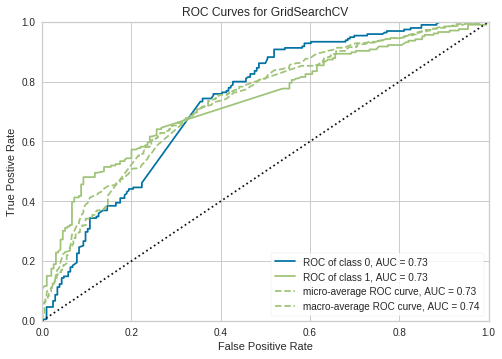

In [0]:
from yellowbrick.classifier import ROCAUC
classes=[0, 1]

# Instantiate the visualizer with the classification model
visualizer = ROCAUC(rf_grid, classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()  

## Model Selection

Based on the precision and F1-score, we have decided to go with RandomForest Classifier.

## LDA Topic Modelling

In [0]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

### Stemming and Lemmatizing

In [0]:
stemmer = SnowballStemmer('english')

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result
  
processed_docs = input_data["review_clean"].map(preprocess)
  
dictionary = gensim.corpora.Dictionary(processed_docs)

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

### Topic Modeling Using Bag of Word

In [0]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[1]

[(24, 2),
 (36, 1),
 (43, 1),
 (73, 1),
 (77, 1),
 (78, 1),
 (79, 2),
 (80, 1),
 (81, 1),
 (82, 1),
 (83, 1)]

Use LDA and the vectorized text from bag of words to identify 20 topics

In [0]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=20, id2word=dictionary, passes=2, workers=2)

Print out all 20 topics

In [0]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.021*"work" + 0.017*"skin" + 0.015*"color" + 0.015*"wash" + 0.014*"time" + 0.013*"towel" + 0.012*"buy" + 0.012*"like" + 0.012*"product" + 0.011*"cloth"
Topic: 1 
Words: 0.024*"work" + 0.014*"time" + 0.012*"tri" + 0.011*"like" + 0.011*"product" + 0.010*"buy" + 0.010*"think" + 0.009*"better" + 0.009*"test" + 0.009*"great"
Topic: 2 
Words: 0.027*"like" + 0.024*"product" + 0.020*"work" + 0.015*"heat" + 0.012*"good" + 0.010*"buy" + 0.009*"time" + 0.009*"take" + 0.009*"year" + 0.009*"problem"
Topic: 3 
Words: 0.035*"skin" + 0.035*"product" + 0.019*"dust" + 0.018*"nail" + 0.018*"good" + 0.016*"like" + 0.013*"swiffer" + 0.012*"work" + 0.011*"time" + 0.010*"great"
Topic: 4 
Words: 0.041*"like" + 0.033*"work" + 0.016*"buy" + 0.015*"time" + 0.011*"take" + 0.010*"think" + 0.010*"product" + 0.010*"go" + 0.008*"need" + 0.008*"want"
Topic: 5 
Words: 0.029*"work" + 0.028*"product" + 0.019*"like" + 0.014*"help" + 0.012*"good" + 0.012*"time" + 0.010*"tast" + 0.010*"look" + 0.009*"buy" 

## Business Impact of Evaluation Metrics

We have given sentiment = 0 for negative sentiment and sentiment =1 for positive sentiment. 

Based on this, false positive is more serious. We do not want to classify a negative sentiment as positive, but rather we are fine to classify some positive sentiments as negative. These false negatives can be renabled and just add friction to the operations. However, a false positive is more serious as it can result in Amazon missing out on negative experiences that customers are having and the effect of this can escalate very quickly to other customers, leaving amazon with very little time to take corrective action

Since we are concerned about false positives more, we want to choose a model having higher precision and f1-score. Additionally, based on the ROCAUC curve we want the results to be closer to the upper left corner for the model to be considered reliable. The more area under the curve, the better.

**Random Forest is the best model on these fronts, after grid search**

##Recommendations

**Industry Application:**
Sentiment analysis is one of the most useful things to apply to investigating unstructured text. In our case, applying the model developed on Amazon Product reviews should be used for the following:

1. Track the sentiment of Amazon products on social media, to capture the image of Amazon as a platform in the eyes of the consumers and take corrective action before its too late
2. Monitor the trend in sentiment over time, is amazon able to make customers happy over time? Or are they losing customers?
3. Identify if sentiment can be localized to specific vendors or product categories and take corrective action accordingly
4. Identify the customers on social media platforms that are leaving specific reviews (negative or positive). How can amazon cater better to these groups?


**Model Improvement Opportunities:**

We have trained our model with 2000 user reviews and vectorized using bi-grams

1. The model can perform more accurately with more reviews
2. If we vectorize it with tri-grams and higher grams , our model will perform much better in predicting the user sentiments
